In [452]:
### code taken from https://dev.to/m0nica/how-to-use-the-tmdb-api-to-find-films-with-the-highest-revenue-82p

import requests # to make TMDB API calls
import locale # to format currency as USD
locale.setlocale( locale.LC_ALL, '' )

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter # to format currency on charts axis
import seaborn as sns
import glob as glob
%matplotlib inline

api_key = '64bc8db1ac9143a7dbb820d7d420ac96'

scrape = False

In [453]:
if scrape == True:

    results = []

    for year in [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]:

        page_number = 1

        response = requests.get('https://api.themoviedb.org/3/discover/movie?api_key=' 
                                 +  api_key + '&page=' + str(page_number) + 
                                 '&with_original_language=en&primary_release_year=' + str(year) + '&with_release_type=3&with_runtime.gte=80')

        total_pages = response.json()['total_pages']
        # total_pages = 5

        results.extend(response.json()['results'])

        while page_number < total_pages:

            page_number += 1

            response = requests.get('https://api.themoviedb.org/3/discover/movie?api_key=' 
                                 +  api_key + '&page=' + str(page_number) + 
                                 '&with_original_language=en&primary_release_year=' + str(year) + '&with_release_type=3&with_runtime.gte=80')

            results.extend(response.json()['results'])
            
else: print('Scrape is set to False.')

Scrape is set to False.


In [454]:
import tmdbsimple as tmdb
tmdb.API_KEY = '64bc8db1ac9143a7dbb820d7d420ac96'

In [455]:
#Importing via CSV to avoid large scrape

df = pd.read_csv('2012-2019.csv')

In [456]:
df.head()

,Unnamed: 0,adult,backdrop_path,genre_ids,id,original_language,original_title,overview,popularity,poster_path,release_date,title,video,vote_average,vote_count
0,0,False,/kwUQFeFXOOpgloMgZaadhzkbTI4.jpg,"[878, 28, 12]",24428,en,The Avengers,When an unexpected enemy emerges and threatens...,151.095,/RYMX2wcKCBAr24UyPD7xwmjaTn.jpg,4/25/2012,The Avengers,False,7.7,24245
1,1,False,/qkl57wzSFrpi2sRpoc2mZJbMuLP.jpg,"[12, 14, 18, 10749]",50620,en,The Twilight Saga: Breaking Dawn - Part 2,"After the birth of Renesmee, the Cullens gathe...",73.226,/jHE7WUf3FDod8vw3O3twh0JVZun.jpg,11/13/2012,The Twilight Saga: Breaking Dawn - Part 2,False,6.5,6978
2,2,False,/ziC23LkMYj8gToQQYQGWSGJCLNF.jpg,"[10751, 16, 35, 12]",82690,en,Wreck-It Ralph,"Wreck-It Ralph is the 9-foot-tall, 643-pound v...",70.213,/nsUAgWCxqbTD9wkKrv3nBGH2DVk.jpg,11/1/2012,Wreck-It Ralph,False,7.3,9689
3,3,False,/jIqxhCZ9aegfVtcBnR4Pn4EgL5o.jpg,"[10751, 35]",105965,en,Beverly Hills Chihuahua 3 - Viva La Fiesta!,When Papi &amp; co move into a luxurious hotel...,67.708,/fK3U8xulldz6lhMDuz3LFB7ngWH.jpg,9/3/2012,Beverly Hills Chihuahua 3 - Viva La Fiesta!,False,6.3,172
4,4,False,/eELGfMwh79VZbLCJEQ0XDOvrQ97.jpg,[35],57214,en,Project X,Three high school seniors throw a party to mak...,67.687,/lUPDGT3lyRrq8SvWuNWG2DP64bR.jpg,3/1/2012,Project X,False,6.7,4398


In [457]:
if scrape == True:

    df_ids = df['id']

    full_movies = []

    for idx in df_ids:
        movie = tmdb.Movies(idx)

        movie_dic = {}

        movie_dic.update(movie.info())

        movie.releases()
        for c in movie.countries:
            if c['iso_3166_1'] == 'US':
                certification = c['certification']
    #         else:
    #             certification = 'None'

        movie_dic.update({'mpaa_rating' : str(certification)})

        full_movies.append(movie_dic)

    df_full = pd.DataFrame(full_movies)

    df_full.to_csv('2012-2019 FULL.csv')
    
else: print('Scrape is set to False.')
    
#### 293471 & 437584 didn't work, make sure to write how i worked around

Scrape is set to False.


In [458]:
#Importing via CSV to avoid large scrape

df_full = pd.read_csv('2012-2019 FULL.csv')

df = df_full

print(df.shape)

df.head(3)

(18846, 27)


,Unnamed: 0,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,mpaa_rating
0,0,False,/kwUQFeFXOOpgloMgZaadhzkbTI4.jpg,"{'id': 86311, 'name': 'The Avengers Collection...",220000000,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",http://marvel.com/avengers_movie/,24428,tt0848228,en,...,1518815515,143.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Some assembly required.,The Avengers,False,7.7,24252,PG-13
1,1,False,/qkl57wzSFrpi2sRpoc2mZJbMuLP.jpg,"{'id': 33514, 'name': 'The Twilight Collection...",120000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,50620,tt1673434,en,...,829000000,115.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The epic finale that will live forever.,The Twilight Saga: Breaking Dawn - Part 2,False,6.5,6978,PG-13
2,2,False,/ziC23LkMYj8gToQQYQGWSGJCLNF.jpg,"{'id': 404825, 'name': 'Wreck-It Ralph Collect...",165000000,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",http://disney.go.com/wreck-it-ralph,82690,tt1772341,en,...,471222889,101.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The story of a regular guy just looking for a ...,Wreck-It Ralph,False,7.3,9690,PG


In [459]:
#https://datatofish.com/list-column-names-pandas-dataframe/

column_list = df.columns.values.tolist()

print(column_list)



['Unnamed: 0', 'adult', 'backdrop_path', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'video', 'vote_average', 'vote_count', 'mpaa_rating']


In [460]:
# columns_to_drop = ['Unnamed: 0', 'adult', 'backdrop_path', 
#                    'belongs_to_collection', 'homepage',  
#                    'original_language',  
#                    'overview', 'poster_path', 
#                    'production_countries', 
#                    'spoken_languages', 
#                    'tagline', 'title', 'video']

# keep'budget''genres''id', 'imdb_id','original_title','popularity', 
# 'production_companies','release_date', 'revenue', 'runtime', 'status',
# 'vote_average', 
# 'vote_count', 'mpaa_rating'

In [461]:
# df.drop(columns=[columns_to_drop], inplace=True)

df = df[['release_date', 'original_title', 'id', 'budget', 'revenue', 'mpaa_rating', 
    'genres', 'popularity', 'vote_average', 'vote_count', 'runtime', 
    'production_companies']]

df.head(3)

,release_date,original_title,id,budget,revenue,mpaa_rating,genres,popularity,vote_average,vote_count,runtime,production_companies
0,4/25/2012,The Avengers,24428,220000000,1518815515,PG-13,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",151.095,7.7,24252,143.0,"[{'id': 420, 'logo_path': '/hUzeosd33nzE5MCNsZ..."
1,11/13/2012,The Twilight Saga: Breaking Dawn - Part 2,50620,120000000,829000000,PG-13,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",73.226,6.5,6978,115.0,"[{'id': 491, 'logo_path': '/rUp0lLKa1pr4UsPm8f..."
2,11/1/2012,Wreck-It Ralph,82690,165000000,471222889,PG,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",70.213,7.3,9690,101.0,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil..."


In [462]:
#filters - need to go back and do more cleaning, make it more pure, but this set is good to work with for now

df = df.loc[df['budget'] >= 1000000] #budget greater than $1mm
df = df.loc[df['revenue'] != 0] #revenue greater than 0, movies with zero indicate no 'real' release

print(df.shape)

df.head(3)

(1365, 12)


,release_date,original_title,id,budget,revenue,mpaa_rating,genres,popularity,vote_average,vote_count,runtime,production_companies
0,4/25/2012,The Avengers,24428,220000000,1518815515,PG-13,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",151.095,7.7,24252,143.0,"[{'id': 420, 'logo_path': '/hUzeosd33nzE5MCNsZ..."
1,11/13/2012,The Twilight Saga: Breaking Dawn - Part 2,50620,120000000,829000000,PG-13,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",73.226,6.5,6978,115.0,"[{'id': 491, 'logo_path': '/rUp0lLKa1pr4UsPm8f..."
2,11/1/2012,Wreck-It Ralph,82690,165000000,471222889,PG,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",70.213,7.3,9690,101.0,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil..."


# Budget

In [463]:
# #create function later
# # https://www.youtube.com/watch?v=ox_AHkeqNJ0&ab_channel=AbhishekAgarrwal

# df['production_budget'] = pd.to_numeric(df['production_budget'].replace('[^0-9\.-]', '', regex=True))
# df['domestic_gross'] = pd.to_numeric(df['domestic_gross'].replace('[^0-9\.-]', '', regex=True))
# df['worldwide_gross'] = pd.to_numeric(df['worldwide_gross'].replace('[^0-9\.-]', '', regex=True))

In [464]:
df.head(3)

,release_date,original_title,id,budget,revenue,mpaa_rating,genres,popularity,vote_average,vote_count,runtime,production_companies
0,4/25/2012,The Avengers,24428,220000000,1518815515,PG-13,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",151.095,7.7,24252,143.0,"[{'id': 420, 'logo_path': '/hUzeosd33nzE5MCNsZ..."
1,11/13/2012,The Twilight Saga: Breaking Dawn - Part 2,50620,120000000,829000000,PG-13,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",73.226,6.5,6978,115.0,"[{'id': 491, 'logo_path': '/rUp0lLKa1pr4UsPm8f..."
2,11/1/2012,Wreck-It Ralph,82690,165000000,471222889,PG,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",70.213,7.3,9690,101.0,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil..."


In [465]:
# insert column tip from: https://discuss.codecademy.com/t/can-we-add-a-new-column-at-a-specific-position-in-a-pandas-dataframe/355842/2

profit = df['revenue'] - df['budget']

df.insert (5, "profit", profit)

df.head(3)

,release_date,original_title,id,budget,revenue,profit,mpaa_rating,genres,popularity,vote_average,vote_count,runtime,production_companies
0,4/25/2012,The Avengers,24428,220000000,1518815515,1298815515,PG-13,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",151.095,7.7,24252,143.0,"[{'id': 420, 'logo_path': '/hUzeosd33nzE5MCNsZ..."
1,11/13/2012,The Twilight Saga: Breaking Dawn - Part 2,50620,120000000,829000000,709000000,PG-13,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",73.226,6.5,6978,115.0,"[{'id': 491, 'logo_path': '/rUp0lLKa1pr4UsPm8f..."
2,11/1/2012,Wreck-It Ralph,82690,165000000,471222889,306222889,PG,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",70.213,7.3,9690,101.0,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil..."


In [466]:
# https://stackoverflow.com/questions/56990755/how-to-create-a-boolean-column-depending-on-positive-or-negative-values-of-anoth      


successful = np.where(df["profit"] >= 0, 'Yes', 'No')

df.insert (5, "successful", successful)

df.head(3)

,release_date,original_title,id,budget,revenue,successful,profit,mpaa_rating,genres,popularity,vote_average,vote_count,runtime,production_companies
0,4/25/2012,The Avengers,24428,220000000,1518815515,Yes,1298815515,PG-13,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",151.095,7.7,24252,143.0,"[{'id': 420, 'logo_path': '/hUzeosd33nzE5MCNsZ..."
1,11/13/2012,The Twilight Saga: Breaking Dawn - Part 2,50620,120000000,829000000,Yes,709000000,PG-13,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",73.226,6.5,6978,115.0,"[{'id': 491, 'logo_path': '/rUp0lLKa1pr4UsPm8f..."
2,11/1/2012,Wreck-It Ralph,82690,165000000,471222889,Yes,306222889,PG,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",70.213,7.3,9690,101.0,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil..."


In [467]:
df['successful'].unique()

array(['Yes', 'No'], dtype=object)

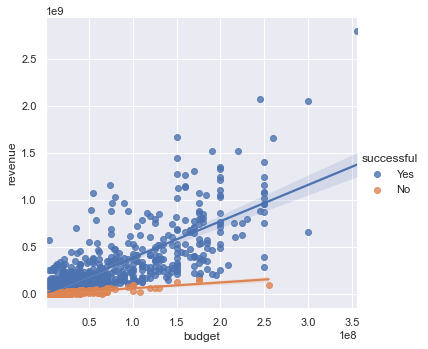

In [468]:
import seaborn as sns; sns.set_theme(color_codes=True)

sns.lmplot(x="budget", y="revenue", data=df, hue="successful")

plt.show()


# Takeaways

In [469]:
df.head(3)

,release_date,original_title,id,budget,revenue,successful,profit,mpaa_rating,genres,popularity,vote_average,vote_count,runtime,production_companies
0,4/25/2012,The Avengers,24428,220000000,1518815515,Yes,1298815515,PG-13,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",151.095,7.7,24252,143.0,"[{'id': 420, 'logo_path': '/hUzeosd33nzE5MCNsZ..."
1,11/13/2012,The Twilight Saga: Breaking Dawn - Part 2,50620,120000000,829000000,Yes,709000000,PG-13,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",73.226,6.5,6978,115.0,"[{'id': 491, 'logo_path': '/rUp0lLKa1pr4UsPm8f..."
2,11/1/2012,Wreck-It Ralph,82690,165000000,471222889,Yes,306222889,PG,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",70.213,7.3,9690,101.0,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil..."


In [470]:
df_genre_list = []

for row in df['genres']:
    row = list(eval(row))
    row_genres = []
    for item in row:
        row_genres.append(item['name'])
    
    df_genre_list.append(row_genres)
    
df['genres'] = df_genre_list

df.head(3)

,release_date,original_title,id,budget,revenue,successful,profit,mpaa_rating,genres,popularity,vote_average,vote_count,runtime,production_companies
0,4/25/2012,The Avengers,24428,220000000,1518815515,Yes,1298815515,PG-13,"[Science Fiction, Action, Adventure]",151.095,7.7,24252,143.0,"[{'id': 420, 'logo_path': '/hUzeosd33nzE5MCNsZ..."
1,11/13/2012,The Twilight Saga: Breaking Dawn - Part 2,50620,120000000,829000000,Yes,709000000,PG-13,"[Adventure, Fantasy, Drama, Romance]",73.226,6.5,6978,115.0,"[{'id': 491, 'logo_path': '/rUp0lLKa1pr4UsPm8f..."
2,11/1/2012,Wreck-It Ralph,82690,165000000,471222889,Yes,306222889,PG,"[Family, Animation, Comedy, Adventure]",70.213,7.3,9690,101.0,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil..."


In [471]:
genre_mean_df = df.explode('genres').groupby('genres').mean().round()
genre_median_df = df.explode('genres').groupby('genres').median().round()

# reset index so that seaborn will work, will not work with columsn as index
# genre_name = []

genre = genre_mean_df.index

genre_mean_df.reset_index(drop=True, inplace=True)
genre_mean_df.insert (0, "genre", genre)

genre_median_df.reset_index(drop=True, inplace=True)
genre_median_df.insert (0, "genre", genre)

In [472]:
genre_mean_df.head(3)

,genre,id,budget,revenue,profit,popularity,vote_average,vote_count,runtime
0,Action,242281.0,83442070.0,275878015.0,192435944.0,54.0,6.0,4671.0,113.0
1,Adventure,240311.0,110242334.0,396482517.0,286240183.0,55.0,7.0,5549.0,113.0
2,Animation,248863.0,85701402.0,343391802.0,257690400.0,41.0,7.0,3422.0,95.0


In [473]:
genre_median_df.head(3)

,genre,id,budget,revenue,profit,popularity,vote_average,vote_count,runtime
0,Action,257344.0,60000000.0,133718711.0,68761661.0,36.0,6.0,3323.0,112.0
1,Adventure,261507.0,103000000.0,255825100.0,138622422.0,38.0,7.0,4052.0,110.0
2,Animation,261812.0,75000000.0,218349271.0,147401898.0,34.0,7.0,2096.0,93.0


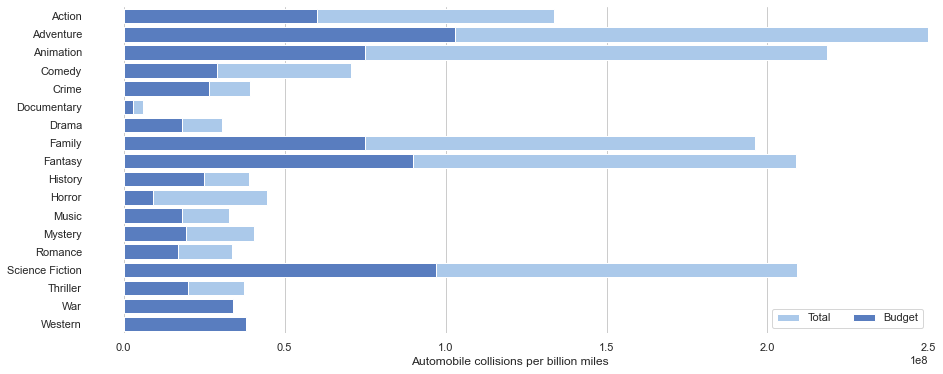

In [474]:
data = genre_median_df

# https://seaborn.pydata.org/examples/part_whole_bars.html
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 6))

# Plot the total crashes
sns.set_color_codes("pastel")

sns.barplot(x="revenue", y="genre", data=data,
            label="Total", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="budget", y="genre", data=data,
            label="Budget", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(-10000000, 250000000), ylabel="",
       xlabel="Automobile collisions per billion miles")
sns.despine(left=True, bottom=True)

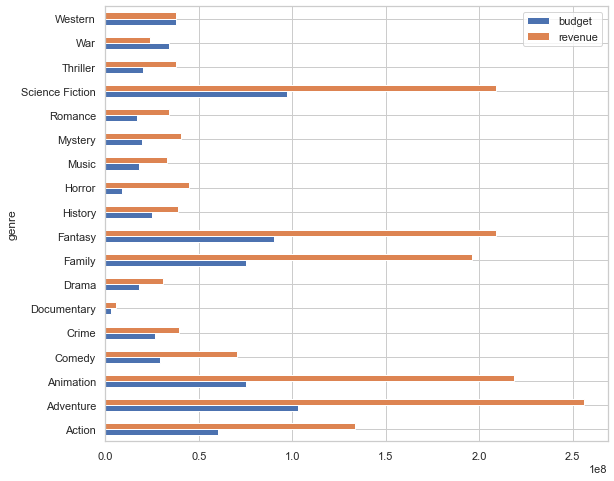

In [475]:
# https://www.delftstack.com/howto/matplotlib/pandas-plot-multiple-columns-on-bar-chart-matplotlib/

import pandas as pd 
import matplotlib.pyplot as plt 


data = genre_median_df
data.plot(x="genre", y=["budget", "revenue"], kind="barh",figsize=(9,8))
plt.show()

# Take aways

# release dates

In [476]:
# type(df['release_date'][0])

df.head(3)

,release_date,original_title,id,budget,revenue,successful,profit,mpaa_rating,genres,popularity,vote_average,vote_count,runtime,production_companies
0,4/25/2012,The Avengers,24428,220000000,1518815515,Yes,1298815515,PG-13,"[Science Fiction, Action, Adventure]",151.095,7.7,24252,143.0,"[{'id': 420, 'logo_path': '/hUzeosd33nzE5MCNsZ..."
1,11/13/2012,The Twilight Saga: Breaking Dawn - Part 2,50620,120000000,829000000,Yes,709000000,PG-13,"[Adventure, Fantasy, Drama, Romance]",73.226,6.5,6978,115.0,"[{'id': 491, 'logo_path': '/rUp0lLKa1pr4UsPm8f..."
2,11/1/2012,Wreck-It Ralph,82690,165000000,471222889,Yes,306222889,PG,"[Family, Animation, Comedy, Adventure]",70.213,7.3,9690,101.0,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil..."


In [477]:
df['release_date'] = pd.to_datetime(df['release_date'])

df.head(3)

,release_date,original_title,id,budget,revenue,successful,profit,mpaa_rating,genres,popularity,vote_average,vote_count,runtime,production_companies
0,2012-04-25,The Avengers,24428,220000000,1518815515,Yes,1298815515,PG-13,"[Science Fiction, Action, Adventure]",151.095,7.7,24252,143.0,"[{'id': 420, 'logo_path': '/hUzeosd33nzE5MCNsZ..."
1,2012-11-13,The Twilight Saga: Breaking Dawn - Part 2,50620,120000000,829000000,Yes,709000000,PG-13,"[Adventure, Fantasy, Drama, Romance]",73.226,6.5,6978,115.0,"[{'id': 491, 'logo_path': '/rUp0lLKa1pr4UsPm8f..."
2,2012-11-01,Wreck-It Ralph,82690,165000000,471222889,Yes,306222889,PG,"[Family, Animation, Comedy, Adventure]",70.213,7.3,9690,101.0,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil..."


In [478]:
year = df['release_date'].dt.year
df.insert (1, "year", year)

month = df['release_date'].dt.month
df.insert (1, "month", month)

In [489]:
# https://stackoverflow.com/questions/37625334/python-pandas-convert-month-int-to-month-name

import calendar

df['month'] = df['month'].apply(lambda x: calendar.month_name[x])

df.head(3)



TypeError: list indices must be integers or slices, not str

In [505]:
df['ROI'] = ((df['profit'] / df['budget']) * 100)

df.head(3)

,release_date,month,year,original_title,id,budget,revenue,successful,profit,mpaa_rating,genres,popularity,vote_average,vote_count,runtime,production_companies,ROI
0,2012-04-25,April,2012,The Avengers,24428,220000000,1518815515,Yes,1298815515,PG-13,"[Science Fiction, Action, Adventure]",151.095,7.7,24252,143.0,"[{'id': 420, 'logo_path': '/hUzeosd33nzE5MCNsZ...",590.370689
1,2012-11-13,November,2012,The Twilight Saga: Breaking Dawn - Part 2,50620,120000000,829000000,Yes,709000000,PG-13,"[Adventure, Fantasy, Drama, Romance]",73.226,6.5,6978,115.0,"[{'id': 491, 'logo_path': '/rUp0lLKa1pr4UsPm8f...",590.833333
2,2012-11-01,November,2012,Wreck-It Ralph,82690,165000000,471222889,Yes,306222889,PG,"[Family, Animation, Comedy, Adventure]",70.213,7.3,9690,101.0,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil...",185.589630


In [494]:
df['month'].value_counts()

September    163
October      146
December     122
March        117
August       112
November     110
June         108
May          103
July         100
February      99
January       98
April         87
Name: month, dtype: int64

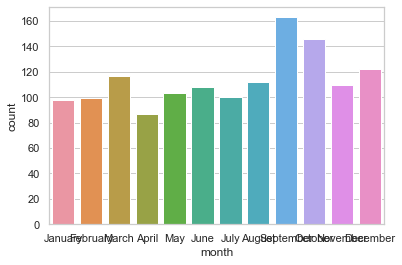

In [495]:
# df['month'].plot(kind="hist")

month_order=['January', 'February', 'March', 'April', 'May', 'June', 'July', 
             'August', 'September', 'October', 'November', 'December']

sns.countplot(data = df, x = 'month', order = month_order)

plt.show()

<AxesSubplot:xlabel='year', ylabel='count'>

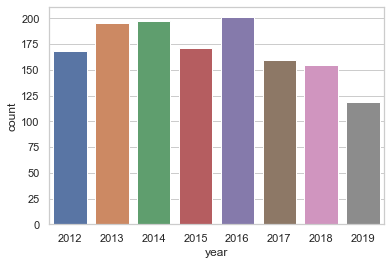

In [488]:
# df['month'].plot(kind="hist")

month_order=['January', 'February', 'March', 'April', 'May', 'June', 'July', 
             'August', 'September', 'October', 'November', 'December']

sns.countplot(data = df, x = 'year')


In [500]:
df.head()

df['mpaa_rating'].value_counts()

R        575
PG-13    489
PG       167
NR        14
G          9
NC-17      1
Name: mpaa_rating, dtype: int64

In [503]:
df.loc[df['original_title'] == 'Rio 2']

df.loc[df['mpaa_rating'] == 'G']

,release_date,month,year,original_title,id,budget,revenue,successful,profit,mpaa_rating,genres,popularity,vote_average,vote_count,runtime,production_companies
2925,2013-06-19,June,2013,Monsters University,62211,200000000,743559607,Yes,543559607,G,"[Animation, Family]",64.315,7.0,8171,104.0,"[{'id': 3, 'logo_path': '/1TjvGVDMYsj6JBxOAkUH..."
2982,2013-07-18,July,2013,Khumba,172391,20000000,27187375,Yes,7187375,G,"[Animation, Adventure, Family]",24.083,6.0,190,85.0,"[{'id': 23953, 'logo_path': '/u5PflbHJXrQ2hyWw..."
3051,2013-12-24,December,2013,The House of Magic,202575,34000000,64197205,Yes,30197205,G,"[Family, Fantasy, Animation, Adventure]",17.245,6.3,255,85.0,"[{'id': 28831, 'logo_path': None, 'name': 'Sho..."
3284,2013-10-16,October,2013,The Young and Prodigious T.S. Spivet,157841,33000000,9494789,No,-23505211,G,"[Adventure, Drama, Family]",10.119,6.8,525,105.0,"[{'id': 7286, 'logo_path': None, 'name': 'Epit..."
6120,2014-03-19,March,2014,Rio 2,172385,103000000,500188435,Yes,397188435,G,"[Family, Adventure, Comedy, Animation]",42.873,6.5,2509,101.0,"[{'id': 9383, 'logo_path': '/ppeMh4iZJQUMm1nAj..."
9259,2015-11-01,November,2015,The Peanuts Movie,227973,99000000,246233113,Yes,147233113,G,"[Adventure, Comedy, Animation, Family]",27.467,6.8,1180,88.0,"[{'id': 9383, 'logo_path': '/ppeMh4iZJQUMm1nAj..."
9349,2015-03-26,March,2015,Ooops! Noah is Gone...,326215,6000000,769028,No,-5230972,G,"[Animation, Adventure, Comedy, Family]",19.910,6.2,215,85.0,"[{'id': 50162, 'logo_path': None, 'name': 'Moe..."
13938,2017-06-15,June,2017,Cars 3,260514,175000000,383925276,Yes,208925276,G,"[Animation, Adventure, Comedy, Drama]",68.539,6.8,3884,102.0,"[{'id': 3, 'logo_path': '/1TjvGVDMYsj6JBxOAkUH..."
17495,2019-06-19,June,2019,Toy Story 4,301528,175000000,1073394593,Yes,898394593,G,"[Adventure, Animation, Comedy, Family, Fantasy...",96.320,7.6,6787,100.0,"[{'id': 2, 'logo_path': '/wdrCwmRnLFJhEoH8GSfy..."


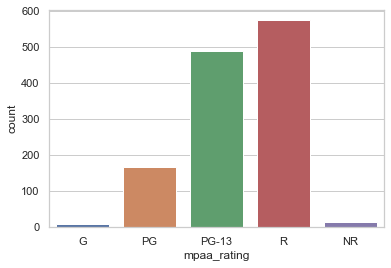

In [498]:
rating_order = ['G', 'PG', 'PG-13', 'R', 'NR']

sns.countplot(data = df, x = 'mpaa_rating', order = rating_order)

plt.show()

In [529]:
mpaa_mean_df = df.groupby('mpaa_rating').mean()

mpaa_median_df = df.groupby('mpaa_rating').median()


rating = mpaa_mean_df.index

mpaa_mean_df.reset_index(drop=False, inplace=True)
# genre_mean_df.insert (0, "genre", genre)

mpaa_median_df.reset_index(drop=False, inplace=True)
# genre_median_df.insert (0, "genre", genre)

In [530]:
mpaa_mean_df

,mpaa_rating,year,id,budget,revenue,profit,popularity,vote_average,vote_count,runtime,ROI
0,G,2014.666667,209292.555556,9.388889e+07,3.387722e+08,2.448833e+08,41.207889,6.666667,2635.111111,95.000000,156.135064
1,NC-17,2015.000000,292431.000000,3.000000e+06,2.490830e+05,-2.750917e+06,12.515000,6.300000,1602.000000,134.000000,-91.697233
2,NR,2014.928571,264686.142857,8.892857e+06,5.529222e+06,-3.363635e+06,14.560500,6.300000,765.642857,100.214286,-4.304487
3,PG,2015.520958,262792.179641,7.438131e+07,2.775577e+08,2.031764e+08,34.764533,6.625749,2965.101796,101.586826,283.903548
4,PG-13,2015.139059,245996.862986,6.483038e+07,2.221026e+08,1.572722e+08,41.435546,6.483436,3939.529652,113.145194,272.112563
5,R,2015.097391,261283.382609,2.531680e+07,7.608808e+07,5.077128e+07,29.847487,6.350087,2596.156522,109.721739,276.385744


In [531]:
mpaa_median_df

,mpaa_rating,year,id,budget,revenue,profit,popularity,vote_average,vote_count,runtime,ROI
0,G,2014.0,202575.0,99000000.0,246233113.0,147233113.0,27.467,6.80,1180.0,100.0,119.385872
1,NC-17,2015.0,292431.0,3000000.0,249083.0,-2750917.0,12.515,6.30,1602.0,134.0,-91.697233
2,NR,2015.0,249149.0,8000000.0,755689.0,-5410070.5,13.237,6.25,479.5,101.0,-58.370360
3,PG,2016.0,267935.0,64000000.0,133821816.0,78695338.0,27.951,6.70,1633.0,99.0,173.237783
4,PG-13,2015.0,254905.0,32000000.0,86165646.0,46788393.0,26.567,6.50,2327.0,111.0,146.060104
5,R,2015.0,257785.0,18000000.0,31724284.0,10361137.0,20.420,6.40,1482.0,107.0,71.439092


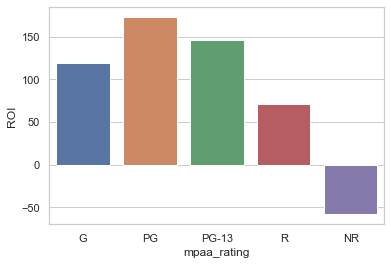

In [534]:
data = mpaa_median_df

rating_order = ['G', 'PG', 'PG-13', 'R', 'NR']

sns.barplot(data = data, x = 'mpaa_rating', y = 'ROI', order = rating_order)

plt.show()

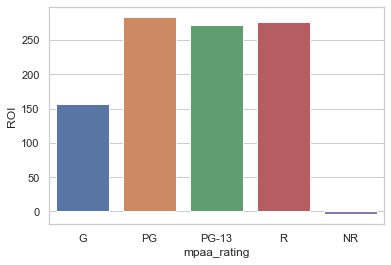

In [535]:
data = mpaa_mean_df

rating_order = ['G', 'PG', 'PG-13', 'R', 'NR']

sns.barplot(data = data, x = 'mpaa_rating', y = 'ROI', order = rating_order)

plt.show()